# Simulation Grid

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path

In [3]:
import astropy.io.fits as fits
import astropy.table

/Users/david/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Define a function to read the per-camera brick files produced by `qso_grid.py`:

In [4]:
def read_bricks(brickname='1234p567', bands='brz', path='../simulate'):
    flux, ivar, wlen = {}, {}, {}
    truth = None
    for band in bands:
        brick = fits.open(os.path.join(path, 'brick-{}-{}.fits'.format(band, brickname)),
                          mode='readonly', memmap=False)
        flux[band] = brick[0].data
        ivar[band] = brick[1].data
        wlen[band] = brick[2].data
        band_truth = astropy.table.Table.read(brick, hdu=4)
        if truth is None:
            truth = band_truth
        elif not np.array_equal(truth, band_truth):
            print 'WARNING: HDU4 truth does not match between bands.'
        brick.close()
    return flux, ivar, wlen, truth

Read simulations of the single `desimodel` template produced with the command:
```
python qso_grid.py --template -1 --brickname single --write-bricks
```

In [5]:
sflux, sivar, swlen, struth = read_bricks('single')

Read noise-free simuations of the single `desimodel` template produced with the command:
```
python qso_grid.py --template -1 --brickname single_truth --write-bricks --no-noise
```

In [6]:
tflux, tivar, twlen, ttruth = read_bricks('single_truth')
assert np.array_equal(sivar['b'], tivar['b'])
assert np.array_equal(swlen['b'], twlen['b'])
assert np.array_equal(struth, ttruth)

Define a function to plot a simulated spectrum across all bands:

In [7]:
def plot(g, z, flux, ivar, wlen, truth, save=None, show_errors=False, true_flux=None):
    # Find the entry closest to the requested (g,z).
    diff = (truth['GBANDT'] - g)**2 + (truth['TRUEZ'] - z)**2
    spec_index = np.argsort(diff)[0]
    g, z = truth['GBANDT'][spec_index], truth['TRUEZ'][spec_index]
    print 'Plotting row {:d} with g={:.1f}, z={:.1f}.'.format(spec_index, g, z)
    
    # Plot each camera's flux scatter.
    b, r, z = flux['b'][spec_index], flux['r'][spec_index], flux['z'][spec_index]
    bmask = ivar['b'][spec_index] > 0
    plt.plot(wlen['b'][spec_index, bmask], b[bmask], 'b.', alpha=0.25)
    rmask = ivar['r'][spec_index] > 0
    plt.plot(wlen['r'][spec_index, rmask], r[rmask], 'r.', alpha=0.25)
    zmask = ivar['z'][spec_index] > 0
    plt.plot(wlen['z'][spec_index, zmask], z[zmask], 'k.', alpha=0.25)

    # Plot curves of flux error = ivar**-0.5.
    if show_errors:
        plt.plot(wlen['b'][spec_index, bmask], ivar['b'][spec_index, bmask]**-0.5, 'g-', alpha=0.5)
        plt.plot(wlen['r'][spec_index, rmask], ivar['r'][spec_index, rmask]**-0.5, 'g-', alpha=0.5)
        plt.plot(wlen['z'][spec_index, zmask], ivar['z'][spec_index, zmask]**-0.5, 'g-', alpha=0.5)
        
    if true_flux is not None:
        plt.fill_between(wlen['b'][spec_index], true_flux['b'][spec_index], color='k', alpha=0.25)
        plt.fill_between(wlen['r'][spec_index], true_flux['r'][spec_index], color='k', alpha=0.25)
        plt.fill_between(wlen['z'][spec_index], true_flux['z'][spec_index], color='k', alpha=0.25)
        plt.plot(wlen['b'][spec_index], true_flux['b'][spec_index], 'k-')
        plt.plot(wlen['r'][spec_index], true_flux['r'][spec_index], 'k-')
        plt.plot(wlen['z'][spec_index], true_flux['z'][spec_index], 'k-')

    plt.xlabel('Wavelength')
    plt.ylabel('Flux 1e-17 ergs/cm**2/s/A')
    plt.xlim(3500., 10000.)
    
    # Pick suitable y limits.
    all_flux = np.hstack([b[b!=0], r[r!=0], z[z!=0]]).flatten()
    ymin, ymax = np.percentile(all_flux, (2.5, 97.5))
    ymin = min(0., ymin)
    plt.ylim(ymin, ymax)
    
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

Plotting row 5 with g=22.0, z=1.0.


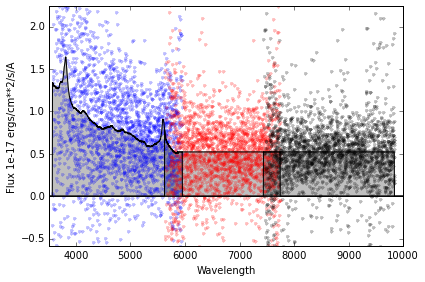

In [8]:
plot(22, 1.0, sflux, sivar, swlen, struth, true_flux=tflux)

Plotting row 25 with g=22.0, z=3.0.


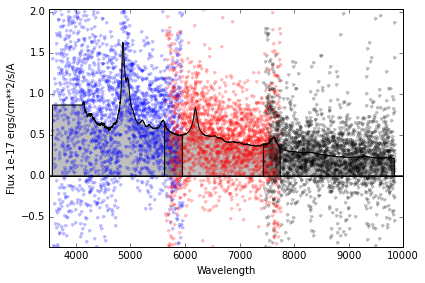

In [9]:
plot(22, 3.0, sflux, sivar, swlen, struth, true_flux=tflux)

Plotting row 129 with g=23.0, z=1.0.


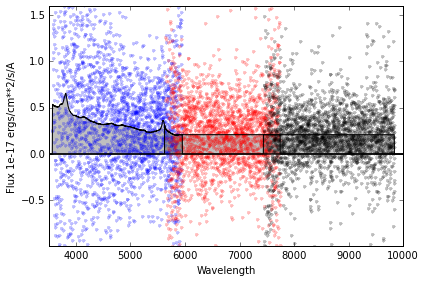

In [10]:
plot(23, 1.0, sflux, sivar, swlen, struth, true_flux=tflux)

Plotting row 149 with g=23.0, z=3.0.


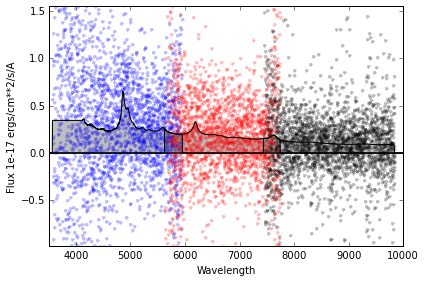

In [11]:
plot(23, 3.0, sflux, sivar, swlen, struth, true_flux=tflux)